## Práctica 1 - Clustering y Detección de Anomalías

Los objetivos de esta práctica son los siguientes:

- Utilizar estos datos de edad y estatura para implementar :
    - Hard-clustering con k-means (no usar sklearn)
    - Soft-clustering con GMM usando sklearn
    
    
- Ejecutar al menos 5 experimentos para seleccionar el valor de “K”
    - Ambos métodos pueden usar el mismo valor de “K”
    - Analizar el centroide de cada cluster y determinar si es posible asignar una categoría  cada cluster


- Analizar y concluir si el método del codo es adecuado para este problema


- Usar los datos de prueba y estimar:
    - El cluster que k-means asigna cada uno.
    - La probabilidad de pertenecer a cada cluster según GMM
    
    
- Detección de anomalías
    - Usar pestaña uno para hacer el entrenamiento del modelo de detección de anomalías
    - Usar pestaña dos y tres como set de validación(seleccionar epsilon) y pruebas
    
## Clustering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal

Se carga el dataset de estaturas y edades con pandas

In [2]:
df = pd.read_csv("estaturas.csv")
df.head()

,Estatura,Edad
0,1.77,26
1,1.74,31
2,1.72,24
3,1.78,34
4,1.65,32


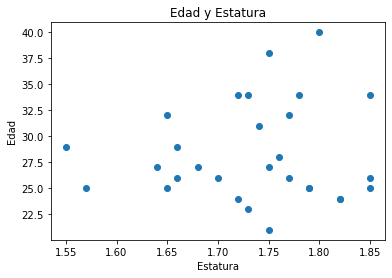

In [3]:
plt.scatter(df["Estatura"],df["Edad"])
plt.xlabel("Estatura")
plt.ylabel("Edad")
plt.title("Edad y Estatura")
plt.show()

### K-means

A continuación se definirá una clase para realizar clustering de la información edad y estatura por medio del algoritmo K-means.

In [4]:
class KMeans:
    def __init__(self,dataset,k,debug=False):
        self.dataset = dataset
        self.k = k
        self.centroids = self.__generate_centroids()
        self.clusters = np.zeros((dataset.shape[0],1))
        self.cost = 0
        self.debug = debug
        
    def __generate_centroids(self):
        centroids = None
        for i in range(self.dataset.shape[1]):
            column = np.random.uniform(np.min(self.dataset[:,i]), np.max(self.dataset[:,i]), self.k).reshape(-1,1)
            centroids = column if centroids is None else np.hstack((centroids,column))
        return centroids
    
    def __euclidean_distance(self, dataset, centroid):
        distance = np.sqrt(np.sum(np.subtract(dataset,centroid)**2,axis=1)).reshape(-1,1)
        return distance
            
    def __get_distances(self, dataset):
        distances = None
        for i in range(self.k):
            distance = self.__euclidean_distance(dataset,self.centroids[i])
            distances = distance if distances is None else np.hstack((distances,distance))
        return distances
    
    def __update_centroids(self):
        for i in range(self.k):
            indices = np.where(self.clusters == i)
            if (indices[0].size):
                self.centroids[i] = np.mean(self.dataset[indices],axis=0)
    
    def fit(self):
        previous_centroids = np.zeros_like(self.centroids)
        while not np.array_equal(self.centroids,previous_centroids):
            distances = self.__get_distances(self.dataset)
            self.clusters = np.argmin(distances,axis=1)
            self.cost = np.mean(np.min(distances,axis=1))
            previous_centroids = self.centroids.copy()
            if self.debug:
                print("Costo: "+str(self.cost))
                print("Actualizando centroides:")
                print(self.centroids)
                print()
            self.__update_centroids()
            
    def predict(self, dataset):
        distances = self.__get_distances(dataset)
        clusters = np.argmin(distances,axis=1)
        return clusters

In [5]:
dataset_train = df[["Estatura","Edad"]].to_numpy(dtype="float64")

kmeans = KMeans(dataset_train,3,True)
kmeans.fit()
clusters = kmeans.predict(dataset_train)
clusters

Costo: 5.9643890561066515
Actualizando centroides:
[[ 1.59052117 33.53975395]
 [ 1.81916107 35.18133277]
 [ 1.77878297 34.2106201 ]]

Costo: 1.4614233486110106
Actualizando centroides:
[[ 1.72478261 26.39130435]
 [ 1.775      39.        ]
 [ 1.77       34.        ]]

Costo: 1.382701033164735
Actualizando centroides:
[[ 1.7255     25.6       ]
 [ 1.775      39.        ]
 [ 1.74857143 33.        ]]



array([0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 1,
       0, 0, 1, 2, 0, 0, 0], dtype=int64)

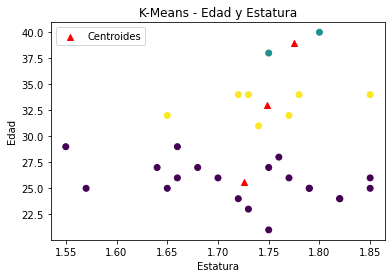

In [6]:
plt.scatter(df["Estatura"],df["Edad"],c=clusters)
plt.scatter(kmeans.centroids[:,0],kmeans.centroids[:,1], marker='^', c='red', label="Centroides")
plt.xlabel("Estatura")
plt.ylabel("Edad")
plt.title("K-Means - Edad y Estatura")
plt.legend()
plt.show()

### Gaussian Mixture Model
Para realizar clustering con Gaussian Mixture Model utilizaremos la clase ya definida en la librería de sklearn.

In [7]:
gmm = GaussianMixture(n_components=3)
gmm.fit(dataset_train)
gmm.predict(dataset_train)
clusters = gmm.predict(dataset_train)

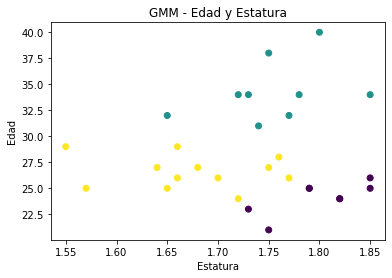

In [8]:
plt.scatter(df["Estatura"],df["Edad"],c=clusters)
plt.xlabel("Estatura")
plt.ylabel("Edad")
plt.title("GMM - Edad y Estatura")
plt.show()

### Encontrando K
Para encontrar el valor de K a utilizar, se correran 5 experimentos y validaremos con el método del codo cuál es el mejor K.

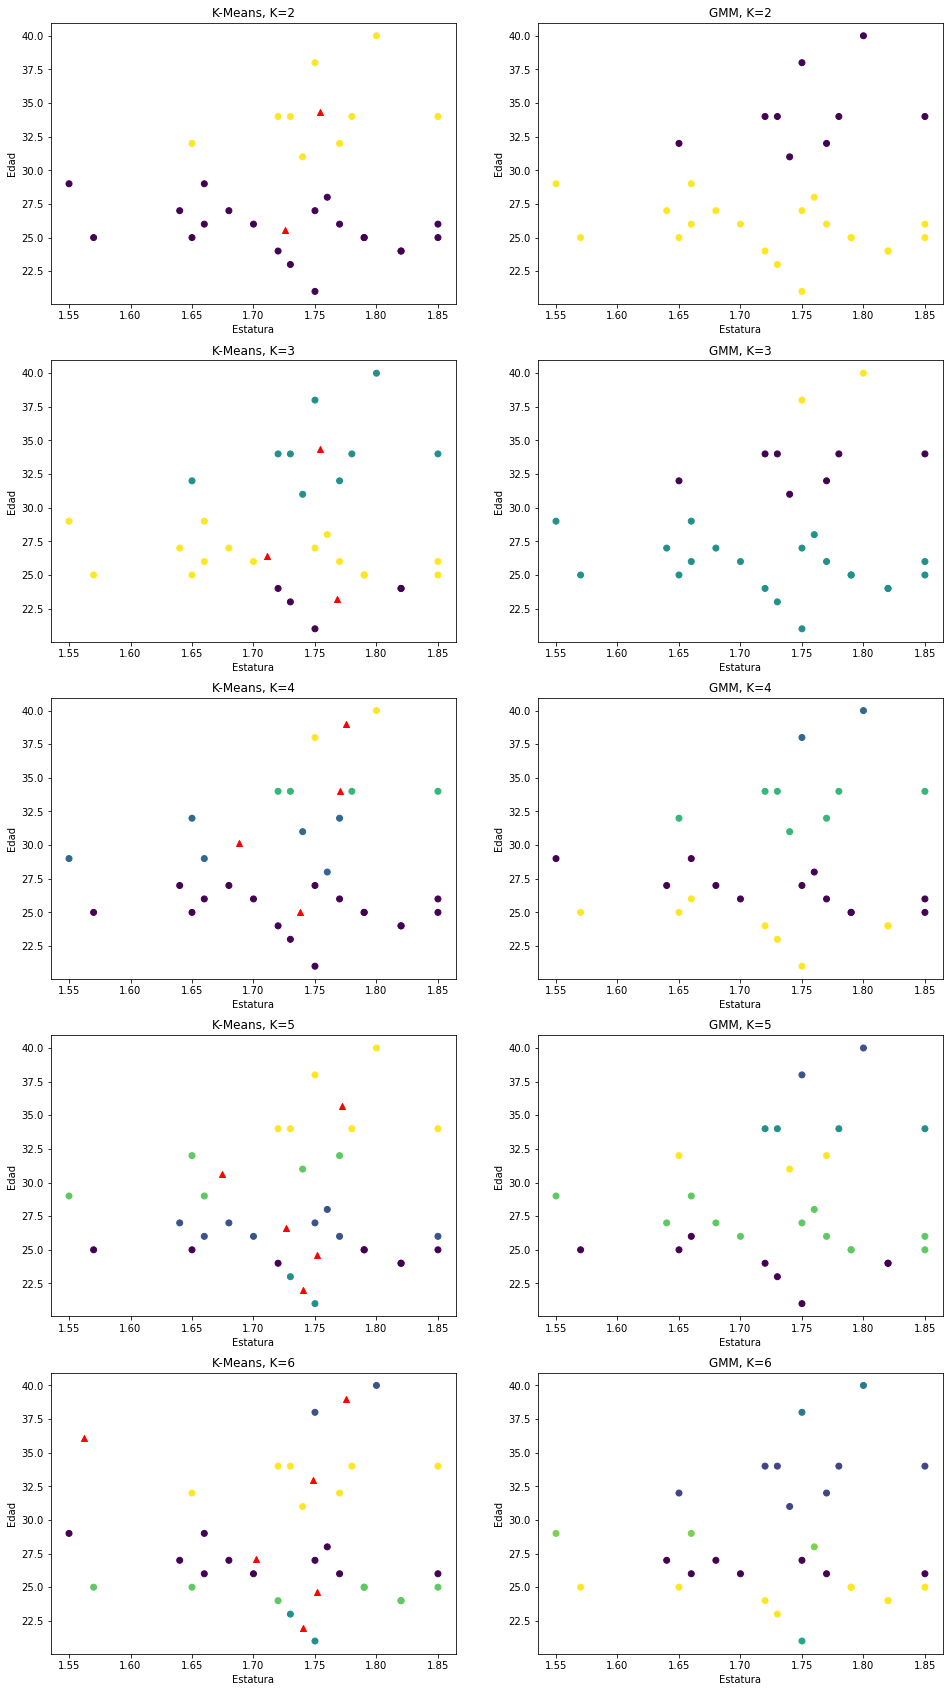

In [9]:
kmeans_costs = list()
f,axes = plt.subplots(5,2,sharex=False, figsize=(16,30))
plot_number = 0
for k in range(2,7):
    kmeans = KMeans(dataset_train,k,False)
    kmeans.fit()
    clusters = kmeans.predict(dataset_train)
    kmeans_costs.append(kmeans.cost)
    
    plot_number += 1
    plt.subplot(5,2, plot_number)
    plt.scatter(df["Estatura"],df["Edad"],c=clusters)
    plt.scatter(kmeans.centroids[:,0],kmeans.centroids[:,1], marker='^', c='red', label="Centroides")
    plt.xlabel("Estatura")
    plt.ylabel("Edad")
    plt.title("K-Means, K="+str(k))
    
    gmm = GaussianMixture(n_components=k)
    gmm.fit(dataset_train)
    clusters = gmm.predict(dataset_train)
    
    plot_number += 1
    plt.subplot(5,2, plot_number)
    plt.scatter(df["Estatura"],df["Edad"],c=clusters)
    plt.xlabel("Estatura")
    plt.ylabel("Edad")
    plt.title("GMM, K="+str(k))
    
plt.show()

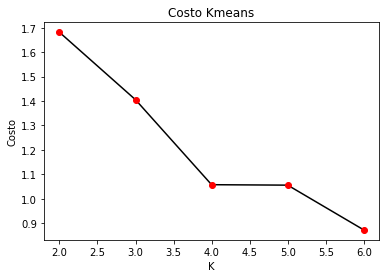

In [10]:
plt.plot(range(2,7), kmeans_costs, 'k' , range(2,7), kmeans_costs,'ro' )
plt.xlabel("K")
plt.ylabel("Costo")
plt.title("Costo Kmeans")
plt.show()

Observando la gráfica de costo obtenida durante los experimentos, podemos definir que el mejor valor de K es 4. 

Analizando las gráficas de clustering durante los experimentos, se puede observar que con un K mayor a 4, algunos centroides quedan sin categoría por lo cual podemos confirmar que el método del codo sí es efectivo para este problema.

### Agrupando datos de prueba
Ahora que ya tenemos el valor de K, se procederá a ralizar una validación con datos no vistos previamente.

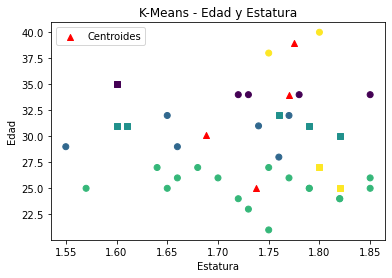

In [11]:
df_test = pd.read_csv("test.csv")
dataset_test = df_test[["Estatura","Edad"]].to_numpy(dtype="float64")

kmeans = KMeans(dataset_train,4,False)
kmeans.fit()
clusters_train = kmeans.predict(dataset_train)
clusters_test = kmeans.predict(dataset_test)

plt.scatter(df["Estatura"],df["Edad"],c=clusters_train)
plt.scatter(df_test["Estatura"],df_test["Edad"],c=clusters_test, marker="s")
plt.scatter(kmeans.centroids[:,0],kmeans.centroids[:,1], marker='^', c='red', label="Centroides")
plt.xlabel("Estatura")
plt.ylabel("Edad")
plt.title("K-Means - Edad y Estatura")
plt.legend()
plt.show()


In [12]:
gmm = GaussianMixture(n_components=4)
gmm.fit(dataset_train)
gmm_clusters_train = gmm.predict(dataset_train)
gmm_clusters_test = gmm.predict(dataset_test)
gmm_probabilities = gmm.predict_proba(dataset_test)

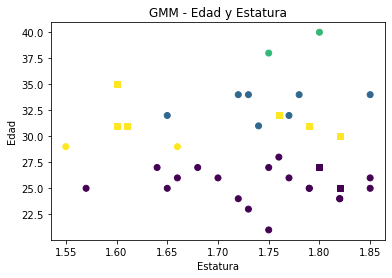

In [13]:
plt.scatter(df["Estatura"],df["Edad"],c=gmm_clusters_train)
plt.scatter(df_test["Estatura"],df_test["Edad"],c=gmm_clusters_test, marker="s")
plt.xlabel("Estatura")
plt.ylabel("Edad")
plt.title("GMM - Edad y Estatura")
plt.show()

In [14]:
cluster_probs = list()
for i in range(len(clusters_test)):
    cluster_probs.append(gmm_probabilities[0][clusters_test[i]])
    
df_test["K-Means cluster"] = clusters_test
df_test["Probabilidad GMM"] = cluster_probs
df_test

,Estatura,Edad,K-Means cluster,Probabilidad GMM
0,1.82,25,2,0.000000e+00
1,1.80,27,2,0.000000e+00
2,1.60,31,1,9.423835e-14
3,1.60,35,0,9.040439e-01
4,1.82,30,1,9.423835e-14
5,1.76,32,1,9.423835e-14
6,1.79,31,1,9.423835e-14
7,1.61,31,1,9.423835e-14


## Detección de anomalías

En esta sección se creará una clase para detección de anomalías, utilizando como datos "normales" los utilizados durante clustering.

In [15]:
df_anomalies = pd.read_csv("anomalias.csv")
df_anomalies

,Estatura,Edad
0,0.25,2.4
1,175.10,2.5
2,0.15,250.0
3,150.00,14.0


In [16]:
class AnomalyDetection:
    def __init__(self,dataset):
        self.dataset = dataset
        
    def fit(self):
        self.mu = np.mean(self.dataset, axis=0)
        self.sigma = np.cov(self.dataset.T)
        self.distribution = multivariate_normal(mean=self.mu, cov=self.sigma)
        self.pdf = self.distribution.pdf
        
    def detect_anomalies(self, dataset, epsilon):
        probabilities = self.pdf(dataset)
        return dataset[np.where(probabilities < epsilon)]

In [17]:
anomaly_detection = AnomalyDetection(dataset_train)
anomaly_detection.fit()

Para encontrar epsilon se realizará una detección de anomalías sobre los datos de prueba.

In [18]:
anomaly_detection.detect_anomalies(dataset_test, 0.05)

array([[ 1.6, 35. ]])

In [23]:
anomaly_detection.detect_anomalies(dataset_test, 0.025)

array([], shape=(0, 2), dtype=float64)

Con un epsilon de 0.05 se identifica 1 anomalía en el dataset de pruebas, sin embargo, al utilizar un epsilon de 0.025 este dato ya no es categorizado como anomalía por lo que se utilizará 0.025 para validar los datos anómalos.

In [20]:
dataset_anomalies =  df_anomalies[["Estatura","Edad"]].to_numpy(dtype="float64")
anomalies = anomaly_detection.detect_anomalies(dataset_anomalies, 0.025)
anomalies

array([[2.500e-01, 2.400e+00],
       [1.751e+02, 2.500e+00],
       [1.500e-01, 2.500e+02],
       [1.500e+02, 1.400e+01]])

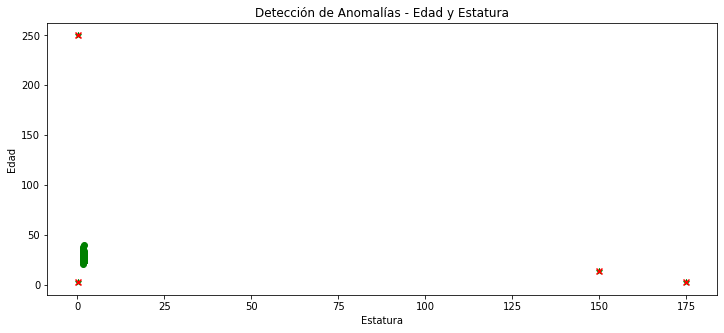

In [21]:
plt.figure(figsize=(12,5))
plt.scatter(df["Estatura"],df["Edad"], color="g")
plt.scatter(df_test["Estatura"],df_test["Edad"], marker="s", color="g")
plt.scatter(df_anomalies["Estatura"],df_anomalies["Edad"], marker="*", color='g')
plt.scatter(anomalies[:,0],anomalies[:,1], marker="x", color="r")
plt.xlabel("Estatura")
plt.ylabel("Edad")
plt.title("Detección de Anomalías - Edad y Estatura")
plt.show()

En la gráfica se puede apreciar que los 4 datos del dataset de anomlías son identificados y son marcados con una X roja.

## Conclusiones

- Los algoritmos de clustering, como K-Means o GMM, son útiles para asignar una categoría a los datos durante el aprendizaje no supervisado y posterior al entrenamiento, poder clasificar nuevos  datos no vistos durante el entrenamiento.


- Durante esta práctica se pudo validar que si se utiliza un K muy grande durante el entrenamiento de K-means, algunas categorías pueden quedar sin datos por lo que podemos basarnos en el método del codo para tener una idea de cuál es el K adecuado para el problema.


- Utilizando la función de densidad de probabilidad de un dataset, es posible identificar datos anómalos en nuevas observaciones.